In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings("ignore")

import os
import datetime

https://www.kaggle.com/rohitsahoo/sales-forecasting

In [38]:
data = pd.read_csv("superstore.csv")

In [39]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [40]:
data.shape

(9800, 18)

In [41]:
data.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

Just the "Postal Code" column has 11 NaNs.

In [42]:
data['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [43]:
data.groupby('Category')['Sales'].count()

Category
Furniture          2078
Office Supplies    5909
Technology         1813
Name: Sales, dtype: int64

In [44]:
# filter the "furniture" from category and sort them by "Order Date"
df = data[data.Category == 'Furniture'].sort_values('Order Date')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
4009,4010,CA-2018-144463,01/01/2018,05/01/2018,Standard Class,SC-20725,Steven Cartwright,Consumer,United States,Los Angeles,California,90036.0,West,FUR-FU-10001215,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Brentwood Wall ...",474.430
8070,8071,CA-2018-151750,01/01/2018,05/01/2018,Standard Class,JM-15250,Janet Martin,Consumer,United States,Huntsville,Texas,77340.0,Central,FUR-FU-10002116,Furniture,Furnishings,"Tenex Carpeted, Granite-Look or Clear Contempo...",141.420
848,849,CA-2018-107503,01/01/2018,06/01/2018,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Lorain,Ohio,44052.0,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",48.896
8071,8072,CA-2018-151750,01/01/2018,05/01/2018,Standard Class,JM-15250,Janet Martin,Consumer,United States,Huntsville,Texas,77340.0,Central,FUR-CH-10003199,Furniture,Chairs,Office Star - Contemporary Task Swivel Chair,310.744
157,158,CA-2015-104269,01/03/2015,06/03/2015,Second Class,DB-13060,Dave Brooks,Consumer,United States,Seattle,Washington,98115.0,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568


In [45]:
# We are interested in Order Date, Category (Furniture) and sales. So, drop the columns except Order Date and Sales
df = df.drop(['Row ID','Order ID', 'Ship Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Product Name'], axis = 1)
df.head()

,Order Date,Sales
4009,01/01/2018,474.430
8070,01/01/2018,141.420
848,01/01/2018,48.896
8071,01/01/2018,310.744
157,01/03/2015,457.568


In [46]:
# Add daily sales to get daywise for each mounth
df = df.groupby('Order Date')['Sales'].sum().reset_index()
df.head()

,Order Date,Sales
0,01/01/2018,975.4900
1,01/03/2015,1893.9950
2,01/03/2016,1412.7504
3,01/03/2017,836.5920
4,01/04/2017,1324.5320


In [47]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format= "%d/%m/%Y" )
print(type(df['Order Date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [48]:
df.head()

,Order Date,Sales
0,2018-01-01,975.4900
1,2015-03-01,1893.9950
2,2016-03-01,1412.7504
3,2017-03-01,836.5920
4,2017-04-01,1324.5320


In [49]:
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2018-01-01', '2015-03-01', '2016-03-01', '2017-03-01',
               '2017-04-01', '2018-04-01', '2016-05-01', '2017-05-01',
               '2018-05-01', '2015-06-01',
               ...
               '2016-07-31', '2017-07-31', '2018-07-31', '2016-08-31',
               '2018-08-31', '2015-10-31', '2016-10-31', '2017-10-31',
               '2015-12-31', '2016-12-31'],
              dtype='datetime64[ns]', name='Order Date', length=877, freq=None)

In [50]:
df.head()

,Sales
Order Date,
2018-01-01,975.4900
2015-03-01,1893.9950
2016-03-01,1412.7504
2017-03-01,836.5920
2017-04-01,1324.5320


In [51]:
# Time series is a sequence taken at successive equally spaced points in time. 
#"resample()" method for frequency conversion and resampling of time series.
# mean command will find the mean closing price of each month for a duration of 12 months.
y = df['Sales'].resample('MS').mean()

In [52]:
y.head(15)

Order Date
2015-01-01     518.106417
2015-02-01     367.931600
2015-03-01     837.845176
2015-04-01     567.488357
2015-05-01     432.049188
2015-06-01     691.820084
2015-07-01     601.169500
2015-08-01     475.014033
2015-09-01     992.353367
2015-10-01     769.015437
2015-11-01     975.956395
2015-12-01    1531.867125
2016-01-01     978.328467
2016-02-01     522.395667
2016-03-01     623.045529
Freq: MS, Name: Sales, dtype: float64

<AxesSubplot:xlabel='Order Date'>

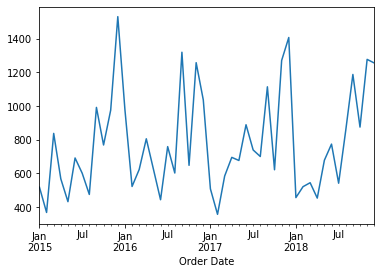

In [53]:
y.plot()

In [54]:
# Split the data into train and test. Last 11 months to predict for testing and the rest of data from beginning for training
y_train = y[:len(y)-11]
y_test = y[(len(y)-11):]

In [55]:
y_train

Order Date
2015-01-01     518.106417
2015-02-01     367.931600
2015-03-01     837.845176
2015-04-01     567.488357
2015-05-01     432.049188
2015-06-01     691.820084
2015-07-01     601.169500
2015-08-01     475.014033
2015-09-01     992.353367
2015-10-01     769.015437
2015-11-01     975.956395
2015-12-01    1531.867125
2016-01-01     978.328467
2016-02-01     522.395667
2016-03-01     623.045529
2016-04-01     805.822962
2016-05-01     624.996700
2016-06-01     443.586529
2016-07-01     759.280000
2016-08-01     602.412012
2016-09-01    1320.285421
2016-10-01     648.027083
2016-11-01    1258.229188
2016-12-01    1036.920509
2017-01-01     508.182867
2017-02-01     356.868273
2017-03-01     584.412476
2017-04-01     695.373158
2017-05-01     676.935227
2017-06-01     889.323143
2017-07-01     739.397588
2017-08-01     700.591665
2017-09-01    1114.811454
2017-10-01     621.737316
2017-11-01    1271.345152
2017-12-01    1407.883269
2018-01-01     456.166308
Freq: MS, Name: Sales, dtyp

<AxesSubplot:xlabel='Order Date'>

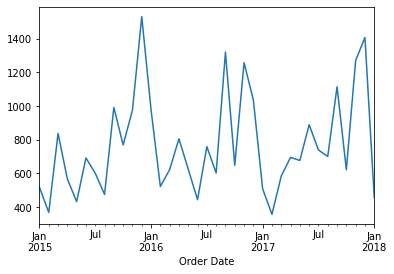

In [56]:
y_train.plot()

<AxesSubplot:xlabel='Order Date'>

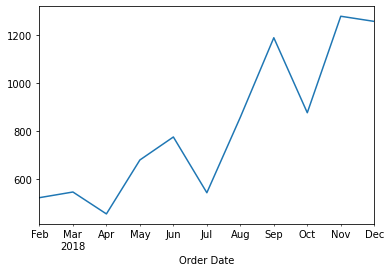

In [57]:
y_test.plot()

## ARIMA
Various methods to find the stationarity of a time series are looking for seasonality or trend in the plot of time series, checking the difference in mean and variance for various time periods, Augmented Dickey-Fuller (ADF) test, KPSS test, Hurst’s exponent etc.

In [58]:
result = adfuller(y_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.127116
p-value: 0.000873
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630


 First we will compare the ADF Statistic with the critical values, a lower critical value tells us the series is most likely non-stationary. Next, we see the p-value. A p-value greater than 0.05 also suggests that the time series is non-stationary.
 
 <img src = "https://www.statisticshowto.com/wp-content/uploads/2014/01/p-value1.jpg" width = 220>
 
 Alternatively, p-value less than or equal to 0.05, or ADF Statistic less than critical values suggest the time series is stationary. Hence, the time series we are dealing with is already stationary. In case of stationary time series, we set the ‘d’ parameter as 0.
 
 We can also confirm the stationarity of time series using **Hurst exponent**, but Series length must be greater or equal to 100

In [59]:
#!pip install hurst
#import hurst

#H, c,data = hurst.compute_Hc(y_train)
#print("H = {:.4f}, c = {:.4f}".format(H,c))

### ACF and PACF

ACF and PACF plots allow you to determine the AR and MA components of an ARIMA model. Both the Seasonal and the non-Seasonal AR and MA components can be determined from the ACF and PACF plots.

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

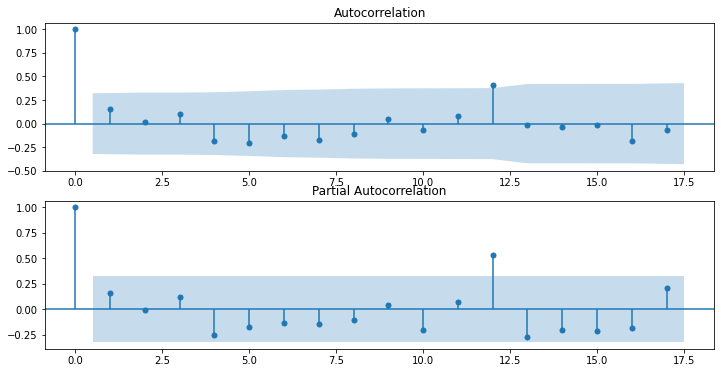

In [61]:
fig, ax = plt.subplots(2, figsize = (12,6))
ax[0] = plot_acf(y_train, ax=ax[0], lags=17)
ax[1] = plot_pacf(y_train, ax=ax[1], lags=17)

## Time series Decomposition
Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.
### Time series components
A given time series is thought to consist of three systematic components (can be modeled) including level, trend, seasonality, and one non-systematic (cannot be directly modeled) component called noise.

`Level`: The average value in the series.
`Trend`: The increasing or decreasing value in the series.
`Seasonality`: The repeating short-term cycle in the series.
`Noise`: The random variation in the series.

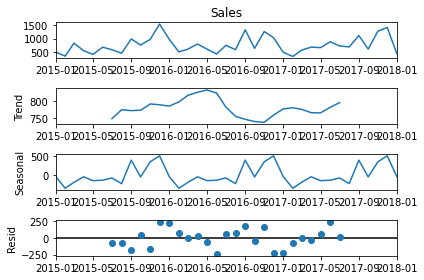

In [62]:
# "additive model" is a linearly increasing trend from 1 to 99 and some random noise and decompose it as an additive model.
ts_decomp = sm.tsa.seasonal_decompose(y_train, model='additive')
ts_decomp.plot()
plt.show()
                                     

The first one is "Observed or True" values. Trend is not specific. Seasonality shows homogeneous peaks during the time and same as true values. Since we have strong seasonality, we use seasonal Arima instead of just Arima. 

***ARIMA Model***, which is characterized by 3 parameter, (p,d,q), **p** or `lag order`: The number of lag observations (p = 3 means 3 periods before). **d** or `degree of deffering`: The number of differencing transformations requiredby time series to get stationary. **q** `order of moving average`: The size of moving average window. In fact q difines error's delay. Error is not defined by trend and seasonality.

**SARIMA** Seasonal Autoregressive Integrated Moving Average, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA. The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order. D: Seasonal difference order. Q: Seasonal moving average order. m: The number of time steps for a single seasonal period.

SARIMA(p,d,q)(P,D,Q)m for example : SARIMA(3,1,0)(1,1,0)12

A `P=1` would make use of the first seasonally offset observation in the model, e.g. t-(m*1) or t-12. A `P=2`, would use the last two seasonally offset observations t-(m * 1), t-(m * 2).

Similarly, a `D of 1` would calculate a first order seasonal difference and a `Q=1` would use a first order errors in the model (e.g. moving average).

In [63]:
p = d = q =range(0,2)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameters combinations for Seasonal Arim...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[5]))

Examples of parameters combinations for Seasonal Arim...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 1) x (1, 0, 1, 12)


In [66]:
metric_aic_dict = dict()

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y_train,
                                             order=pm,
                                             seasonal_order=pm_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model_aic = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(pm, pm_seasonal, model_aic.aic))
            metric_aic_dict.update({(pm, pm_seasonal):model_aic.aic})
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:588.1579266077384
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:940.8418673356468
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:332.9748727216562
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:159.6884227953729
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:351.28566458017434
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:333.2478750207625
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:174.3189030974817
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:159.44320194295946
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:548.7933155407549
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1843.1693069054265
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:321.75411668764946
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:148.9128226329278
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:353.5834881070385
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:322.36404103463764
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:175.20924866327502
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:148.59569284017235
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:519.4983794007017
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:337.33795758674796
AR

In [67]:
{k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{((0, 1, 1), (0, 1, 1, 12)): 137.64599079910144,
 ((1, 1, 1), (0, 1, 1, 12)): 139.63783508570788,
 ((0, 1, 1), (1, 1, 1, 12)): 140.8142274149239,
 ((1, 1, 1), (1, 1, 1, 12)): 142.0399717143531,
 ((0, 0, 1), (1, 1, 1, 12)): 148.59569284017235,
 ((0, 0, 1), (0, 1, 1, 12)): 148.9128226329278,
 ((1, 0, 1), (0, 1, 1, 12)): 150.00895802355365,
 ((1, 0, 1), (1, 1, 1, 12)): 150.5827030426116,
 ((0, 1, 0), (0, 1, 1, 12)): 151.57346313499858,
 ((0, 1, 0), (1, 1, 1, 12)): 152.88853121872438,
 ((1, 1, 0), (0, 1, 1, 12)): 153.078457809629,
 ((1, 1, 0), (1, 1, 0, 12)): 153.0829438752409,
 ((1, 1, 1), (1, 1, 0, 12)): 153.45136246157946,
 ((1, 1, 0), (1, 1, 1, 12)): 154.61146550578968,
 ((0, 0, 0), (1, 1, 1, 12)): 159.44320194295946,
 ((0, 0, 0), (0, 1, 1, 12)): 159.6884227953729,
 ((1, 0, 0), (1, 1, 1, 12)): 160.48948307088205,
 ((1, 0, 0), (1, 1, 0, 12)): 160.95990746623124,
 ((1, 0, 0), (0, 1, 1, 12)): 161.02515462383946,
 ((1, 0, 1), (1, 1, 0, 12)): 163.0070621824712,
 ((0, 1, 0), (1, 1, 0, 12)): 

137.64599079910144 is thev smallest AIC and we choose ((0, 1, 1), (0, 1, 1, 12)): 137.64599079910144.
### Fitting the model with the smallest AIC
   
    

In [79]:
model = sm.tsa.statespace.SARIMAX(y_train,
                                             order=(0, 1, 1),
                                             seasonal_order=(0, 1, 1, 12),
                                             #enforce_stationarity=False,
                                             enforce_invertibility=False)
model_aic = model.fit()
print(model_aic.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1804.320     -0.001      1.000   -3537.402    3535.402
ma.S.L12      -1.0000   1804.478     -0.001      1.000   -3537.712    3535.712
sigma2      2.872e+04      0.057   5.02e+05      0.000    2.87e+04    2.87e+04


### Model Diagnastic to calculate the resuduals

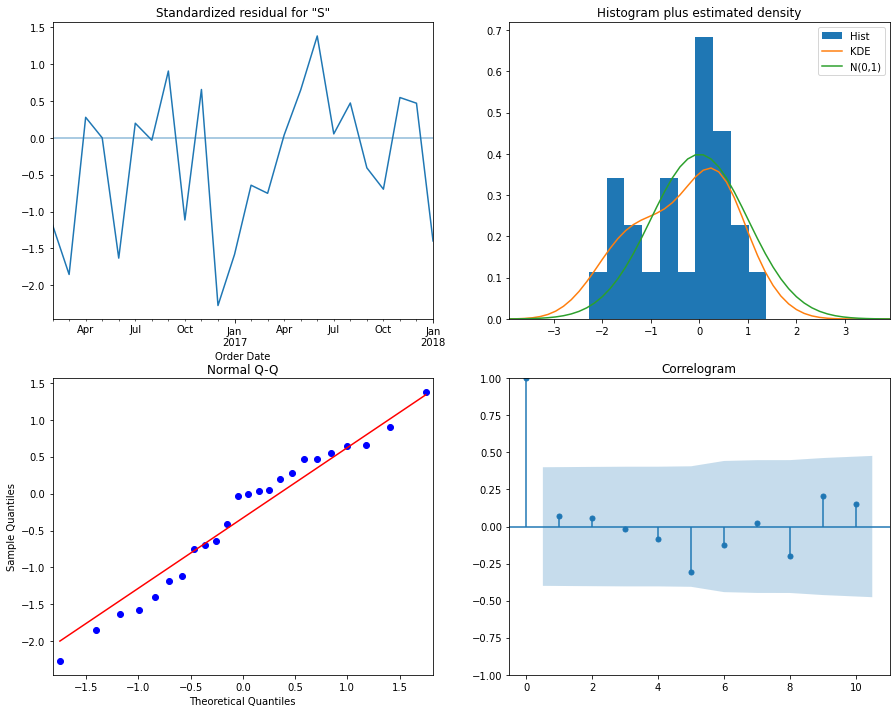

In [80]:
model_aic.plot_diagnostics(figsize=(15, 12))
plt.show()

## Calculating RMSE

In [87]:
forcast = model_aic.get_prediction(start = pd.to_datetime('2018-02-01'), dynamic = False)
predictions = forcast.predicted_mean

actual = y_test['2017-02-01':]

rmse = np.sqrt((predictions - actual)**2).mean()
print('The Root Mean Squared error of our forecast is {}'.format(round(rmse,2)))

The Root Mean Squared error of our forecast is 59.0


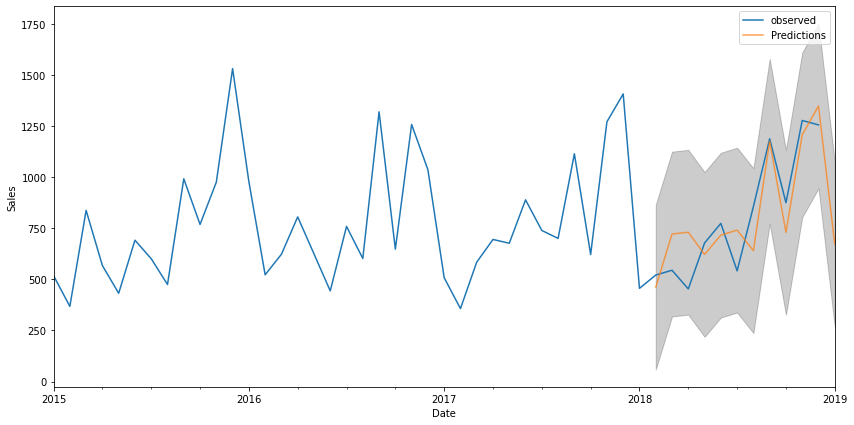

In [88]:
forecast = model_aic.get_forecast(steps=12)

# predictions and confidence interval
predictions= forecast.predicted_mean
ci = forecast.conf_int()

# observed plot
fig = y.plot(label = 'observed', figsize = (14,7))
fig.set_xlabel('Date')
fig.set_ylabel('Sales')
fig.fill_between(ci.index,
                ci.iloc[:,0],
                ci.iloc[:,1], color = 'k', alpha=.2)

# prediction plot
predictions.plot(ax=fig, label='Predictions', alpha=.7, figsize=(14,7))

plt.legend()
plt.show()